In [ ]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT HOSPITAL SERVICES OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [1]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SEMC01"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

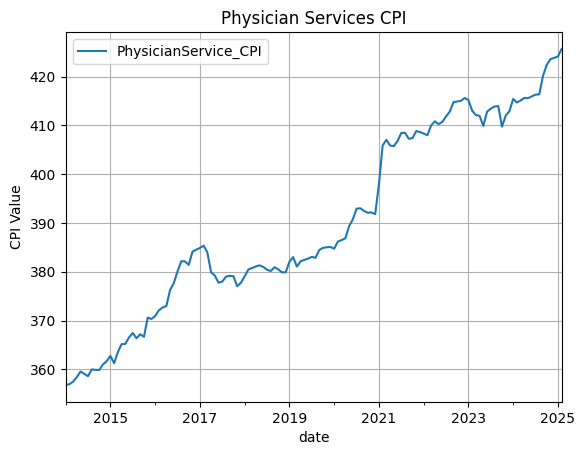

In [3]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF PHYSICIAN SERVICES CPI.

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'PhysicianService_CPI'}, inplace=True)

# Plot
df.plot(title='Physician Services CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

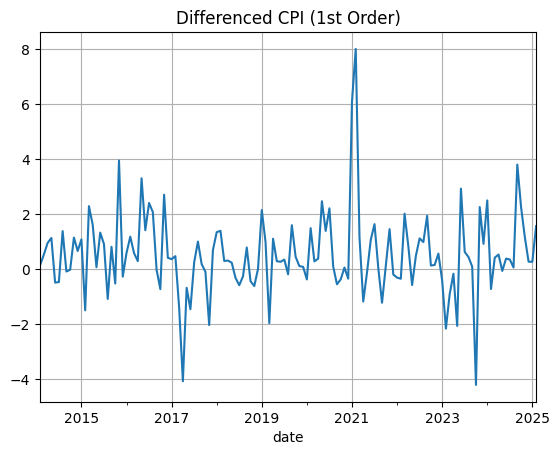

In [4]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['PhysicianService_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

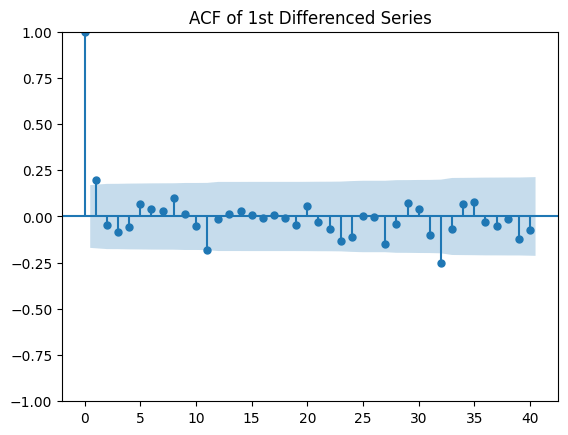

In [5]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

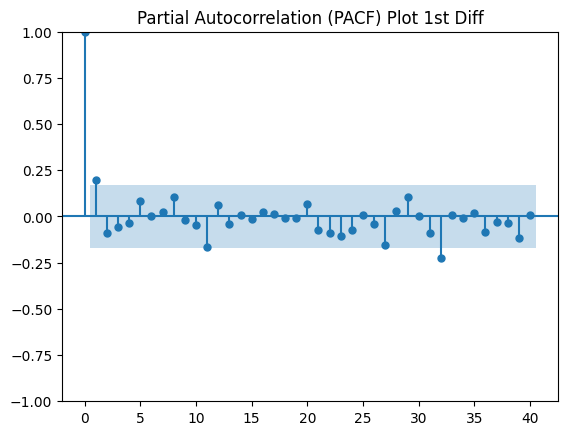

In [6]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [7]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -9.31116001543246
p-value: 1.0481647115946916e-15


In [8]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [9]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [10]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

    lb_stat  lb_pvalue
10  0.00546        1.0


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [11]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.000099   0.992057
2   0.000099   0.999950
3   0.000210   0.999999
4   0.000361   1.000000
5   0.001974   1.000000
6   0.002626   1.000000
7   0.003783   1.000000
8   0.004760   1.000000
9   0.005060   1.000000
10  0.005460   1.000000
11  0.005643   1.000000
12  0.005789   1.000000
13  0.012771   1.000000
14  0.018185   1.000000
15  0.018281   1.000000
16  0.019503   1.000000
17  0.020014   1.000000
18  0.020059   1.000000
19  0.025653   1.000000
20  0.025889   1.000000


In [12]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

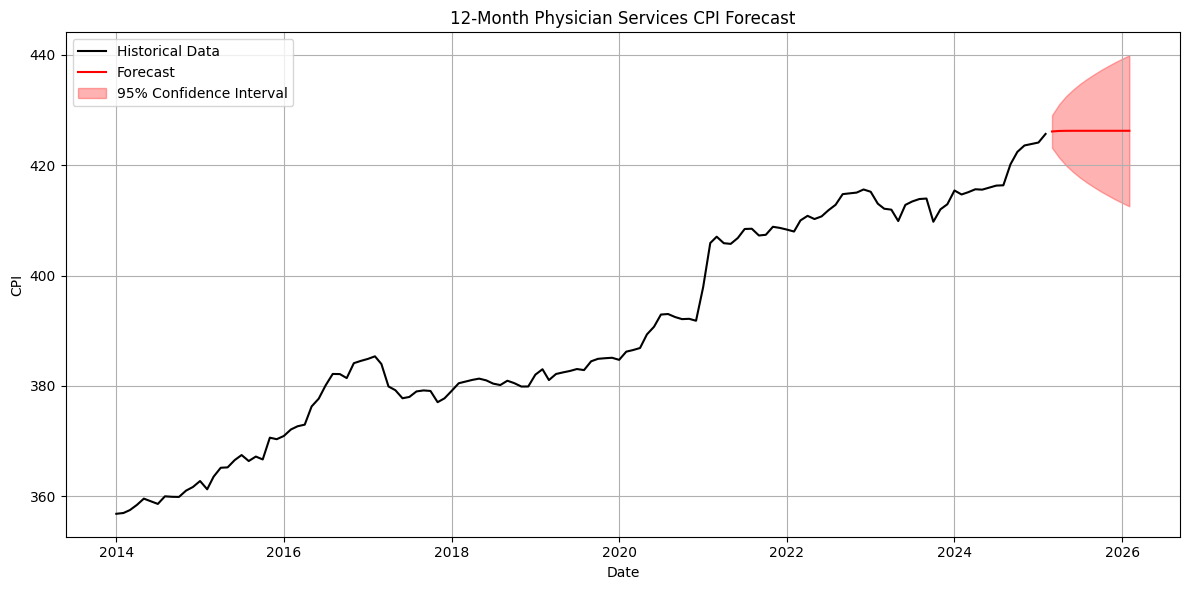

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Physician Services CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-03-01    426.127229
2025-04-01    426.225478
2025-05-01    426.247256
2025-06-01    426.252084
2025-07-01    426.253154
2025-08-01    426.253391
2025-09-01    426.253444
2025-10-01    426.253455
2025-11-01    426.253458
2025-12-01    426.253458
2026-01-01    426.253459
2026-02-01    426.253459
Freq: MS, Name: predicted_mean, dtype: float64


In [16]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [17]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  426.127229      423.162269      429.092190
2025-04-01  426.225478      421.392251      431.058705
2025-05-01  426.247256      419.969793      432.524720
2025-06-01  426.252084      418.782803      433.721365
2025-07-01  426.253154      417.753214      434.753093
2025-08-01  426.253391      416.834024      435.672758
2025-09-01  426.253444      415.996558      436.510329
2025-10-01  426.253455      415.222421      437.284490
2025-11-01  426.253458      414.499142      438.007774
2025-12-01  426.253458      413.817857      438.689060
2026-01-01  426.253459      413.172004      439.334913
2026-02-01  426.253459      412.556571      439.950346


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. PHYSICIAN SERVICES BASED ON CPI
# HAS SOME WHITE NOISE IN THE ACF AND PACF PLOTS, BUT...
# THE ADF AND LJUNG-BOX TEST P-VALUES TELL US THE MODEL HAS GREAT DATA FOR THE FORECAST
# NO NEED TO CONTINUE DIFFERENCING THE DATA AS IT IS STATIONARY IN THIS MODEL